# Data Movement and Resource Monitoring, I/O and GPU Memory

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
report_interval = 50 #ps
proteins = { 'fs-pep': {'residue':23, 'folding_time':14},
            'BBA': {'residue':20, 'folding_time':325},
            'VHP': {'residue':35, 'folding_time':125},
            'NTL9': {'residue':39, 'folding_time':1100},
            'a3d': {'residue':70, 'folding_time':707},
           }

dsize = np.dtype(np.float64).itemsize # 8
data = []
print ("protein_name, residue, folding time, number_of_frames, data_size, data_size_in_gb")
for protein_name, v in proteins.items():
    residue = v['residue']
    ftime = v['folding_time']
    frame_size = residue ** 2 * dsize
    number_of_frames = ftime / report_interval * 1000 ** 2 # millisecond to nanosecond 
    data_size = frame_size * number_of_frames
    data_size_in_gb = data_size / (1000**3)
    temp = [residue, ftime, data_size_in_gb]
    data.append(temp)
    print(protein_name, residue, ftime, number_of_frames, data_size, data_size_in_gb)

protein_name, residue, folding time, number_of_frames, data_size, data_size_in_gb
fs-pep 23 14 280000.0 1184960000.0 1.18496
BBA 20 325 6500000.0 20800000000.0 20.8
VHP 35 125 2500000.0 24500000000.0 24.5
NTL9 39 1100 22000000.0 267696000000.0 267.696
a3d 70 707 14140000.0 554288000000.0 554.288


## Data sizes with simulations

Contact matrices are extracted during the simulations for the training and the inference stages. The figure below is updated with the size of contact maps in colors. And this gives an idea how much data will be written in files and be loaded in GPU devices.

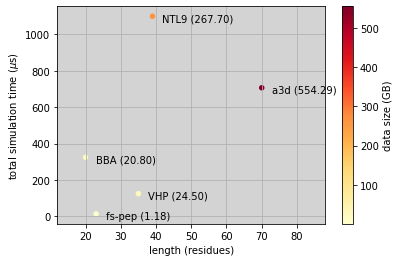

In [4]:
df = pd.DataFrame(data,
                  columns=['length (residues)', 'simulation time', 'data size (GB)'])
ax1 = df.plot.scatter(x='length (residues)',
                      y='simulation time',
                      c='data size (GB)',
                      colormap='YlOrRd', sharex=False)
ax1.set_xlabel('length (residues)')
ax1.set_ylabel('total simulation time ($\mu$s)') #folding time
ax1.set_facecolor('lightgrey')
ax1.grid()
ax1.set_xlim(12,88)
names = list(proteins.keys())
for k, v in df.iterrows():
    k = "{} ({:.2f})".format(names[k],v[2])
    ax1.annotate(k, v[0:2],xytext=(10,-5), textcoords='offset points')

- dot color: total data size in gigabyte (yellow: low, red: high)
- annotation: protein name with data size

### Data sizes during iterations

In a typical configuration of DeepDriveMD, there is a certain number of iterations i.e. 10 to run simulation, training and inference stages. The plot shows how fast the data increases over the iteration with different number of residues.

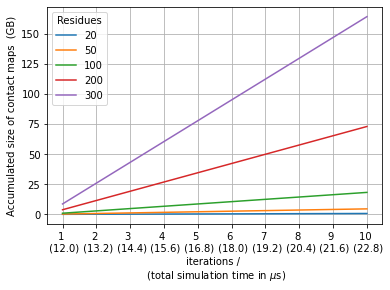

In [6]:
concurrency_cnt = 120 
iter_cnt = 10
init_sim_steps = 100
sim_steps = 10 # ns
report_interval = 50 #ps
frame_cnt = sim_steps / report_interval * 1000
gb_conv = 10**9
residues = [20, 50, 100, 200, 300]
element_size = 8 # bytes
data2 = []
iters = list(range(1,iter_cnt+1))
for i in iters:
    tmp = []
    for j in residues:
        frame_cnt_tmp = frame_cnt
        if i == 1:
            frame_cnt_tmp = init_sim_steps
        tmp.append(concurrency_cnt * frame_cnt_tmp * j * j  * element_size / gb_conv)
    data2.append(tmp)
df3 = pd.DataFrame(data2, 
                   columns=residues,
                   index=iters)

ax=df3.cumsum().plot()
ax.set_xticks(iters)
ax.set_xticklabels(["{} \n ({})".format(1, init_sim_steps * concurrency_cnt / 1000)] + ["{} \n ({})".format(x + 1, (init_sim_steps + x * sim_steps) * concurrency_cnt / 1000 ) for x in iters[:len(iters) - 1]])
ax.set_xlabel('iterations / \n (total simulation time in $\mu$s)')
ax.set_ylabel('Accumulated size of contact maps  (GB)')
ax.legend(title='Residues')
ax.grid()

- total number of simulations: 1200 (120 each over 10 iterations)
- sim time of 1st iteration: 100ns
- sim time of rest: 10ns

## Resource monitoring for I/O and GPU performance
It would make sense to monitor resource usage for the data movement across stages and there are two options available, a performance report and real time monitoring on I/O and GPU.
- a performance report: ARM Performance tools (perf-reports) are used to provide an overview of resources at a task level.
- real time monitoring: nvidia utility (nvidia-smi) has a monitoring feature to report gpu utilization and memory usage at a device level.

RADICAL Cybertools are equipped with these options.

### Example: Report of simulation stage

```
Command:        /ccs/home/hrlee/.conda/envs/workflow-2/bin/python run_openmm.py -f ../../../Parameters/input_adrp/prot.pdb -p ../../../Parameters/input_adrp/prot.prmtop -l 1
Resources:      1 node (44 physical, 176 logical cores per node)
Memory:         605 GiB per node
Tasks:          1 process
Machine:        f13n03
Start time:     Thu Aug 6 2020 02:06:31 (UTC-04)
Total time:     418 seconds (about 7 minutes)
Full path:      /autofs/nccs-svm1_home1/hrlee/.conda/envs/workflow-2/bin

Summary: python is Compute-bound in this configuration
Compute:                                     98.7% |=========|
I/O:                                          1.3% ||
This application run was Compute-bound. A breakdown of this time and advice for investigating further is in the CPU Metrics section below.
As very little time is spent in MPI calls, this code may also benefit from running at larger scales.

I/O:
A breakdown of the 1.3% I/O time:
Time in reads:                               58.3% |=====|
Time in writes:                              41.7% |===|
Effective process read rate:                   369 MB/s
Effective process write rate:                  586 MB/s
Most of the time is spent in read operations with an average effective transfer rate. It may be possible to achieve faster effective transfer rates using asynchronous file operations.

Memory:
Per-process memory usage may also affect scaling:
Mean process memory usage:                     897 MiB
Peak process memory usage:                    1.04 GiB
Peak node memory usage:                       5.0% ||
The peak node memory usage is very low. Larger problem sets can be run before scaling to multiple nodes.


```

## Example: GPU monitoring on different stages

Text(0.5, 0, 'elapsed time (s)')

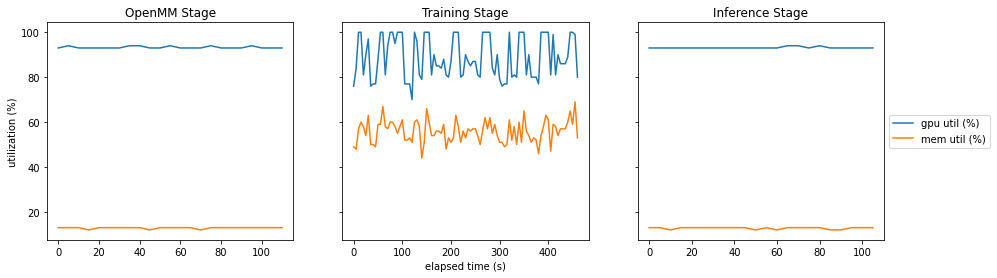

In [8]:
gpu_monitor_openmm = [[0, 188, 35, 31, 93, 13, 0, 0, 877, 1530], [0, 191, 39, 34, 94, 13, 0, 0, 877, 1530], [0, 197, 40, 35, 93, 13, 0, 0, 877, 1530], [0, 198, 40, 35, 93, 12, 0, 0, 877, 1530], [0, 191, 38, 34, 93, 13, 0, 0, 877, 1530], [0, 195, 40, 35, 93, 13, 0, 0, 877, 1530], [0, 190, 40, 35, 93, 13, 0, 0, 877, 1530], [0, 187, 40, 36, 94, 13, 0, 0, 877, 1530], [0, 175, 40, 35, 94, 13, 0, 0, 877, 1530], [0, 200, 40, 36, 93, 12, 0, 0, 877, 1530], [0, 202, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 195, 40, 36, 94, 13, 0, 0, 877, 1530], [0, 198, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 191, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 172, 39, 35, 93, 12, 0, 0, 877, 1530], [0, 194, 40, 36, 94, 13, 0, 0, 877, 1530], [0, 194, 41, 36, 93, 13, 0, 0, 877, 1530], [0, 196, 41, 36, 93, 13, 0, 0, 877, 1530], [0, 176, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 203, 41, 36, 94, 13, 0, 0, 877, 1530], [0, 175, 41, 36, 93, 13, 0, 0, 877, 1530], [0, 195, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 194, 41, 36, 93, 13, 0, 0, 877, 1530]]
gpu_monitor_train = [[0, 260, 41, 39, 76, 49, 0, 0, 877, 1530], [0, 256, 42, 39, 84, 48, 0, 0, 877, 1522], [0, 208, 43, 42, 100, 57, 0, 0, 877, 1425], [0, 319, 44, 43, 100, 60, 0, 0, 877, 1410], [0, 247, 43, 42, 81, 58, 0, 0, 877, 1530], [0, 125, 42, 41, 90, 54, 0, 0, 877, 1522], [0, 264, 43, 42, 97, 63, 0, 0, 877, 1500], [0, 223, 41, 43, 76, 50, 0, 0, 877, 1530], [0, 110, 43, 42, 77, 50, 0, 0, 877, 1530], [0, 233, 43, 42, 77, 49, 0, 0, 877, 1522], [0, 102, 41, 42, 88, 59, 0, 0, 877, 1530], [0, 214, 44, 43, 100, 59, 0, 0, 877, 1432], [0, 325, 44, 43, 100, 67, 0, 0, 877, 1485], [0, 250, 43, 43, 81, 58, 0, 0, 877, 1530], [0, 89, 43, 41, 94, 57, 0, 0, 877, 1522], [0, 264, 44, 43, 100, 60, 0, 0, 877, 1447], [0, 336, 44, 43, 100, 60, 0, 0, 877, 1462], [0, 248, 44, 42, 95, 58, 0, 0, 877, 1522], [0, 217, 42, 42, 100, 55, 0, 0, 877, 1447], [0, 235, 44, 43, 100, 58, 0, 0, 877, 1462], [0, 251, 43, 42, 100, 61, 0, 0, 877, 1522], [0, 174, 42, 43, 77, 52, 0, 0, 877, 1530], [0, 73, 42, 43, 77, 52, 0, 0, 877, 1530], [0, 95, 43, 42, 77, 53, 0, 0, 877, 1530], [0, 257, 43, 42, 70, 51, 0, 0, 877, 1530], [0, 150, 43, 43, 100, 60, 0, 0, 877, 1522], [0, 255, 44, 43, 96, 61, 0, 0, 877, 1432], [0, 347, 45, 44, 81, 58, 0, 0, 877, 1470], [0, 223, 43, 42, 79, 44, 0, 0, 877, 1530], [0, 252, 43, 43, 100, 51, 0, 0, 877, 1515], [0, 200, 44, 44, 100, 66, 0, 0, 877, 1477], [0, 245, 44, 44, 100, 60, 0, 0, 877, 1395], [0, 278, 44, 44, 81, 54, 0, 0, 877, 1530], [0, 329, 43, 43, 90, 54, 0, 0, 877, 1522], [0, 264, 43, 42, 85, 56, 0, 0, 877, 1530], [0, 184, 42, 43, 85, 56, 0, 0, 877, 1530], [0, 131, 42, 43, 84, 55, 0, 0, 877, 1530], [0, 204, 42, 41, 88, 59, 0, 0, 877, 1530], [0, 237, 45, 44, 81, 48, 0, 0, 877, 1432], [0, 255, 43, 44, 80, 53, 0, 0, 877, 1530], [0, 253, 44, 42, 87, 51, 0, 0, 877, 1530], [0, 169, 42, 42, 100, 53, 0, 0, 877, 1515], [0, 227, 44, 43, 100, 63, 0, 0, 877, 1477], [0, 241, 44, 44, 100, 58, 0, 0, 877, 1410], [0, 338, 44, 43, 80, 51, 0, 0, 877, 1515], [0, 226, 44, 44, 81, 56, 0, 0, 877, 1530], [0, 244, 44, 42, 90, 53, 0, 0, 877, 1522], [0, 78, 42, 43, 87, 57, 0, 0, 877, 1530], [0, 120, 43, 42, 85, 56, 0, 0, 877, 1530], [0, 164, 43, 43, 87, 57, 0, 0, 877, 1522], [0, 214, 43, 42, 87, 57, 0, 0, 877, 1530], [0, 321, 44, 43, 81, 54, 0, 0, 877, 1477], [0, 226, 43, 42, 80, 50, 0, 0, 877, 1530], [0, 256, 43, 42, 100, 56, 0, 0, 877, 1522], [0, 243, 44, 43, 100, 62, 0, 0, 877, 1507], [0, 276, 45, 44, 100, 57, 0, 0, 877, 1447], [0, 293, 45, 44, 100, 62, 0, 0, 877, 1447], [0, 289, 43, 43, 84, 55, 0, 0, 877, 1530], [0, 251, 44, 42, 81, 59, 0, 0, 877, 1530], [0, 246, 44, 43, 90, 54, 0, 0, 877, 1530], [0, 117, 43, 42, 79, 51, 0, 0, 877, 1530], [0, 120, 42, 43, 76, 51, 0, 0, 877, 1530], [0, 140, 42, 43, 77, 49, 0, 0, 877, 1530], [0, 246, 43, 41, 77, 50, 0, 0, 877, 1530], [0, 240, 44, 43, 100, 61, 0, 0, 877, 1432], [0, 334, 43, 43, 80, 52, 0, 0, 877, 1530], [0, 231, 43, 42, 81, 58, 0, 0, 877, 1530], [0, 282, 43, 42, 80, 50, 0, 0, 877, 1530], [0, 79, 43, 42, 100, 60, 0, 0, 877, 1530], [0, 228, 44, 43, 100, 51, 0, 0, 877, 1522], [0, 240, 44, 43, 100, 65, 0, 0, 877, 1500], [0, 331, 45, 44, 81, 56, 0, 0, 877, 1447], [0, 225, 44, 44, 90, 54, 0, 0, 877, 1470], [0, 241, 44, 42, 80, 51, 0, 0, 877, 1530], [0, 232, 44, 43, 80, 53, 0, 0, 877, 1530], [0, 122, 43, 43, 80, 52, 0, 0, 877, 1530], [0, 277, 43, 42, 77, 46, 0, 0, 877, 1530], [0, 129, 42, 43, 100, 54, 0, 0, 877, 1515], [0, 234, 44, 44, 100, 58, 0, 0, 877, 1515], [0, 233, 44, 43, 100, 63, 0, 0, 877, 1447], [0, 336, 44, 44, 100, 61, 0, 0, 877, 1485], [0, 230, 43, 43, 81, 47, 0, 0, 877, 1530], [0, 249, 44, 43, 99, 59, 0, 0, 877, 1522], [0, 242, 44, 44, 81, 58, 0, 0, 877, 1477], [0, 249, 44, 43, 90, 54, 0, 0, 877, 1485], [0, 257, 44, 42, 86, 57, 0, 0, 877, 1530], [0, 258, 44, 43, 86, 57, 0, 0, 877, 1530], [0, 297, 43, 42, 86, 57, 0, 0, 877, 1530], [0, 100, 43, 44, 89, 60, 0, 0, 877, 1530], [0, 230, 44, 43, 100, 65, 0, 0, 877, 1500], [0, 211, 44, 44, 100, 59, 0, 0, 877, 1410], [0, 277, 44, 44, 99, 69, 0, 0, 877, 1530], [0, 250, 44, 43, 80, 53, 0, 0, 877, 1530]]
gpu_monitor_infer = [[0, 181, 38, 34, 93, 13, 0, 0, 877, 1530], [0, 196, 40, 35, 93, 13, 0, 0, 877, 1530], [0, 192, 40, 35, 93, 12, 0, 0, 877, 1530], [0, 182, 40, 35, 93, 13, 0, 0, 877, 1530], [0, 194, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 195, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 198, 39, 35, 93, 13, 0, 0, 877, 1530], [0, 177, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 186, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 201, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 204, 40, 36, 93, 12, 0, 0, 877, 1530], [0, 193, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 189, 41, 36, 93, 12, 0, 0, 877, 1530], [0, 196, 40, 36, 94, 13, 0, 0, 877, 1530], [0, 178, 41, 36, 94, 13, 0, 0, 877, 1530], [0, 196, 41, 36, 93, 13, 0, 0, 877, 1530], [0, 193, 40, 35, 94, 13, 0, 0, 877, 1530], [0, 187, 40, 36, 93, 12, 0, 0, 877, 1530], [0, 206, 41, 36, 93, 12, 0, 0, 877, 1530], [0, 189, 41, 36, 93, 13, 0, 0, 877, 1530], [0, 166, 40, 36, 93, 13, 0, 0, 877, 1530], [0, 199, 41, 36, 93, 13, 0, 0, 877, 1530]]
gpu_monitor_names = ['gpu', 'pwr', 'gtemp', 'mtemp', 'sm', 'mem', 'enc', 'dec', 'mclk', 'pclk']

monitor_interval = 5 #sec

df_openmm = pd.DataFrame(gpu_monitor_openmm, columns=gpu_monitor_names, index=np.arange(0, len(gpu_monitor_openmm) * monitor_interval, monitor_interval))
df_train = pd.DataFrame(gpu_monitor_train, columns=gpu_monitor_names, index=np.arange(0, len(gpu_monitor_train) * monitor_interval, monitor_interval))
df_infer = pd.DataFrame(gpu_monitor_infer, columns=gpu_monitor_names, index=np.arange(0, len(gpu_monitor_infer) * monitor_interval, monitor_interval))

df_openmm_u = df_openmm.rename(columns={'sm':"gpu util (%)", "mem":"mem util (%)"})
df_infer_u = df_infer.rename(columns={'sm':"gpu util (%)", "mem":"mem util (%)"})
df_train_u = df_train.rename(columns={'sm':"gpu util (%)", "mem":"mem util (%)"})

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,4))

df_openmm_u[['gpu util (%)','mem util (%)']].plot(ax=axes[0], legend=False)
df_train_u[['gpu util (%)','mem util (%)']].plot(ax=axes[1], legend=False)
df_infer_u[['gpu util (%)','mem util (%)']].plot(ax=axes[2])
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('OpenMM Stage')
axes[1].set_title('Training Stage')
axes[2].set_title('Inference Stage')
axes[0].set_ylabel('utilization (%)')
axes[1].set_xlabel('elapsed time (s)')


- x-axis: the data is sliced for demonstration purposes while these stages are running
- interval of x-axis: every 5 seconds
- physical memory size: 16GB